In [29]:
# Pacotes

import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import geopandas as gpd
from shapely import wkt
from pyproj import Transformer
import osmnx as ox

In [30]:
# Bancos de dados

oss = r'C:\Users\amand\Amanda\Doutorado\Artigo indicadores OSS\Coordenadas 2025\oss_bhviva_magalhaes_29.08.2025.dta'
virtual_completo = r'C:\Users\amand\Amanda\Analises\Auditoria Virtual\Auditoria Virtual Amostra Total - 27 cidades.dta'

oss = pd.read_stata(oss)
virtual_completo = pd.read_stata(virtual_completo)

print(oss.shape)
print(virtual_completo.shape)

C:\Users\amand\AppData\Local\Temp\ipykernel_26612\4133911849.py:6: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  oss = pd.read_stata(oss)


(373, 690)
(2639, 221)


In [31]:
# Dados da auditoria virtual apenas para Belo Horizonte (a OSS só foi coletada em Belo Horizonte)

virtual = virtual_completo[virtual_completo['cidade'] == 'Belo Horizonte']

virtual.shape

(165, 221)

In [32]:
# Manter apenas as variáveis de interesse

oss = oss[['setor', 'vila_entorno', 'data_obs_1', 'X_inicio', 'Y_inicio', 'X_final', 'Y_final']]

virtual = virtual[['identificador', 'data_imagens', 'wkt', 'coordenadas_inicio', 'coordenadas_termino', 'coordenadas_inicio_2', 'coordenadas_termino_2']]

print(oss.shape)
print(virtual.shape)

(373, 7)
(165, 7)


In [33]:
# Coordenadas OSS

# 1. Criar colunas de coordenadas como tupla
oss['X_Y_inicio'] = list(zip(oss['X_inicio'], oss['Y_inicio']))
oss['X_Y_termino'] = list(zip(oss['X_final'], oss['Y_final']))

# 2. Definir transformador UTM para WGS 84 (assumindo UTM zona 23S - EPSG:31983)
transformer = Transformer.from_crs("EPSG:31983", "EPSG:4326", always_xy=True)

# 3. Função de conversão
def converter_utm_para_latlon(coordenada):
    if coordenada is None or coordenada == (None, None):
        return (None, None)
    x, y = coordenada
    lon, lat = transformer.transform(x, y)
    return (lat, lon)

# 4. Aplicar conversão
oss['coordenadas_inicio'] = oss['X_Y_inicio'].apply(converter_utm_para_latlon)
oss['coordenadas_termino'] = oss['X_Y_termino'].apply(converter_utm_para_latlon)

# 5. Transformar em string no formato "lat, lon"
oss['coordenadas_inicio'] = oss['coordenadas_inicio'].apply(
    lambda coord: f"{coord[0]:.6f}, {coord[1]:.6f}" if coord != (None, None) else None
)
oss['coordenadas_termino'] = oss['coordenadas_termino'].apply(
    lambda coord: f"{coord[0]:.6f}, {coord[1]:.6f}" if coord != (None, None) else None
)

# 6. Excluir coordenadas ausentes (n=3)
oss = oss[~((oss['coordenadas_inicio'] == 'nan, nan') & (oss['coordenadas_termino'] == 'nan, nan'))]

oss.shape

(370, 11)

In [34]:
# Organizar variáveis OSS

oss = oss.rename(columns={'setor': 'id'})
oss['id'] = oss['id'].str.replace('-', '', regex=False)

oss = oss.rename(columns={'vila_entorno': 'area'})

oss = oss.rename(columns={'data_obs_1': 'data'})
oss['data'] = pd.to_datetime(oss['data'], dayfirst=True, errors='coerce')

oss = oss.drop(columns=[col for col in ['X_inicio', 'Y_inicio', 'X_final', 'Y_final', 'X_Y_inicio', 'X_Y_termino'] if col in oss.columns])

oss.head(2)

,id,area,data,coordenadas_inicio,coordenadas_termino
0,0562002001,Serra Entorno,2019-10-16,"-19.930972, -43.919790","-19.930047, -43.919318"
1,0562002002,Serra Entorno,2019-10-16,"-19.929102, -43.919936","-19.930047, -43.919318"


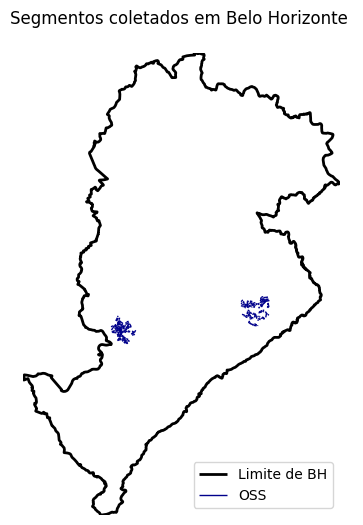

In [39]:
# Plot OSS

def string_to_point(coord_str):
    if coord_str is None or pd.isna(coord_str):
        return None
    lat_str, lon_str = coord_str.split(", ")
    return float(lon_str), float(lat_str)

def string_to_linestring(row):
    start = string_to_point(row['coordenadas_inicio'])
    end = string_to_point(row['coordenadas_termino'])
    if start is None or end is None:
        return None
    return LineString([start, end])

oss['geometry'] = oss.apply(string_to_linestring, axis=1)

gdf_oss = gpd.GeoDataFrame(oss, geometry='geometry', crs="EPSG:4326")

gdf_bh = ox.geocode_to_gdf("Belo Horizonte, Brazil")

fig, ax = plt.subplots(figsize=(5, 6))

gdf_bh.boundary.plot(ax=ax, edgecolor='black', linewidth=2, label="Limite de BH")

gdf_oss.plot(ax=ax, color='darkblue', linewidth=1, alpha=1, label="OSS")

xmin, ymin, xmax, ymax = gdf_bh.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title("Segmentos coletados em Belo Horizonte \n", fontsize=12)
ax.axis("off")

ax.legend(loc="lower right")

plt.show()

In [37]:
# Organizar variáveis auditoria virtual

virtual = virtual.rename(columns={'identificador': 'id'})
virtual = virtual.rename(columns={'data_imagens': 'data'})

virtual['id'] = virtual['id'].astype(str)

virtual.head(2)

,id,data,wkt,coordenadas_inicio,coordenadas_termino,coordenadas_inicio_2,coordenadas_termino_2
770,31062002545.0,2023-01-01,"LineString (-43.9297086 -19.9343585, -43.93032...","-19.9343585, -43.9297086","-19.9342022, -43.9303236","-19.93444030605733, -43.92944989523843",
771,310620010353.0,2024-04-01,"LineString (-43.9240432 -19.9312851, -43.92385...","-19.9312851, -43.9240432","-19.9305887, -43.9238548",,"-19.930604793801137, -43.92380611241607"


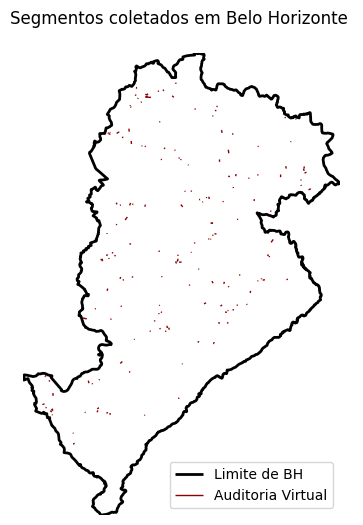

In [42]:
# Plot auditoria virtual

def string_to_point(coord_str):
    if coord_str is None or pd.isna(coord_str):
        return None
    lat_str, lon_str = coord_str.split(", ")
    return float(lon_str), float(lat_str)

def string_to_linestring(row):
    start = string_to_point(row['coordenadas_inicio'])
    end = string_to_point(row['coordenadas_termino'])
    if start is None or end is None:
        return None
    return LineString([start, end])

virtual['geometry'] = virtual['wkt'].apply(wkt.loads)

gdf_virtual = gpd.GeoDataFrame(virtual, geometry='geometry', crs="EPSG:4326")

gdf_bh = ox.geocode_to_gdf("Belo Horizonte, Brazil")

fig, ax = plt.subplots(figsize=(5, 6))

gdf_bh.boundary.plot(ax=ax, edgecolor='black', linewidth=2, label="Limite de BH")

gdf_virtual.plot(ax=ax, color='darkred', linewidth=1, alpha=1, label="Auditoria Virtual")

xmin, ymin, xmax, ymax = gdf_bh.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title("Segmentos coletados em Belo Horizonte \n", fontsize=12)
ax.axis("off")

ax.legend(loc="lower right")

plt.show()

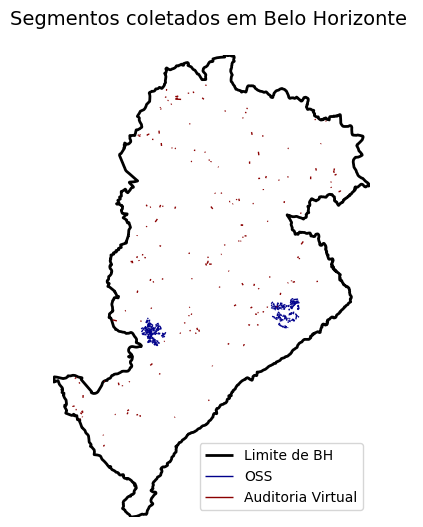

In [43]:
# Função para converter string coordenada "lat, lon" para (lon, lat) ponto shapely
def string_to_point(coord_str):
    if coord_str is None or pd.isna(coord_str):
        return None
    lat_str, lon_str = coord_str.split(", ")
    return float(lon_str), float(lat_str)

# Função para converter duas strings de coordenadas em um LineString
def string_to_linestring(row):
    start = string_to_point(row['coordenadas_inicio'])
    end = string_to_point(row['coordenadas_termino'])
    if start is None or end is None:
        return None
    return LineString([start, end])

# Construir GeoDataFrame OSS
oss['geometry'] = oss.apply(string_to_linestring, axis=1)
gdf_oss = gpd.GeoDataFrame(oss, geometry='geometry', crs="EPSG:4326")

# Construir GeoDataFrame Virtual (usando WKT)
virtual['geometry'] = virtual['wkt'].apply(wkt.loads)
gdf_virtual = gpd.GeoDataFrame(virtual, geometry='geometry', crs="EPSG:4326")

# Obter limite municipal Belo Horizonte
gdf_bh = ox.geocode_to_gdf("Belo Horizonte, Brazil")

# Plot
fig, ax = plt.subplots(figsize=(5, 6))

# Limite municipal BH
gdf_bh.boundary.plot(ax=ax, edgecolor='black', linewidth=2, label="Limite de BH")

# Segmentos OSS
gdf_oss.plot(ax=ax, color='darkblue', linewidth=1, alpha=1, label="OSS")

# Segmentos auditoria virtual
gdf_virtual.plot(ax=ax, color='darkred', linewidth=1, alpha=1, label="Auditoria Virtual")

# Ajustar limites do mapa para o limite municipal
xmin, ymin, xmax, ymax = gdf_bh.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Título e layout
ax.set_title("Segmentos coletados em Belo Horizonte \n", fontsize=14)
ax.axis("off")

# Legenda
ax.legend(loc="lower right")

plt.show()